In [4]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize as op
import pickle
from astropy.table import Column
from astropy.table import Table
from sklearn.decomposition import PCA
from scipy.spatial.distance import pdist
from itertools import product
from scipy.spatial import distance_matrix
%matplotlib inline

In [5]:
N = 5             # number of stars
D = 7             # number of pixels
Q = 3             # number of labels/latent dimensions, Q<=L

In [6]:
np.random.seed(42)
X = np.random.uniform(0, 1, (N, D))          # data
Y = np.random.normal(0, 1, (N, Q))           # labels

In [7]:
# radius basis function
def kernelRBF(Z, rbf):   
    B = B_matrix(Z)
    band = 1.
    kernel = rbf * np.exp(band * B) 
    return kernel

# dimensionless log kernel
def B_matrix(Z):
    N = Z.shape[0]
    B = np.zeros((N, N))
    for entry in list(product(range(N), repeat=2)):
        i, j = entry
        B[i, j] = -0.5 * np.dot((Z[i, :] - Z[j, :]).T, (Z[i, :] - Z[j, :]))
    return B

In [8]:
# initialize parameters
theta_rbf, gamma_rbf = np.pi, np.pi
hyper_params = np.array([theta_rbf, gamma_rbf])
Z_initial = Y[:] 
Z = np.reshape(Z_initial, (N*Q,))

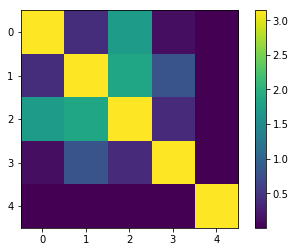

In [9]:
kernel1 = kernelRBF(Z_initial, theta_rbf)
plt.imshow(kernel1, interpolation = None)
plt.colorbar()

In [10]:
# derivative of the kernel with respect to the latent variables Z
def dKdZ(Z, rbf):
    kernel = kernelRBF(Z, rbf)
    A = A_matrix(Z)
    band = 1.
    grad_dKdZ = band * kernel[:, :, None, None] * A
    return grad_dKdZ

def A_matrix(Z): 
    N, Q = Z.shape[0], Z.shape[1]
    A = np.zeros((N, N, N, Q))
    for entry in list(product(range(N), repeat=3)):
        i, j, l = entry
        if l == j:
            A[i, j, l, :] += Z[i, :] - Z[l, :]
        if l == i:
            A[i, j, l, :] += Z[j, :] - Z[l, :]
    return A 

In [11]:
# testing the derivatives
grad_dKdZ = dKdZ(Z_initial, theta_rbf)
print grad_dKdZ.shape

(5, 5, 5, 3)


In [12]:
# derivative with respect to the 2nd latent variable of the 4th object
q = 1
l = 3
A_lq = np.zeros((N, N))
for entry in list(product(range(N), repeat=2)):
    i, j = entry
    if j == l:
        A_lq[i, j] += Z_initial[i, q] - Z_initial[l, q]
    if i == l:
        A_lq[i, j] += Z_initial[j, q] - Z_initial[l, q]
print A_lq

[[ 0.          0.          0.          2.21255893  0.        ]
 [ 0.          0.          0.          0.24356692  0.        ]
 [ 0.          0.          0.          1.25959125  0.        ]
 [ 2.21255893  0.24356692  1.25959125  0.          2.45875884]
 [ 0.          0.          0.          2.45875884  0.        ]]


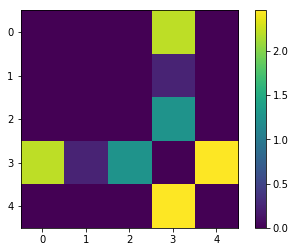

In [13]:
plt.imshow(A_lq, interpolation = None)
plt.colorbar()

# analytical derivative of the kernel

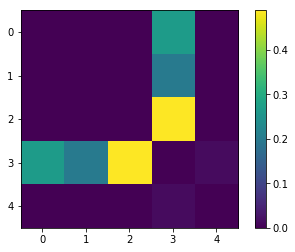

In [14]:
grad_dKdZ_analytic = kernel1 * A_lq
plt.imshow(grad_dKdZ_analytic, interpolation = None)
plt.colorbar()

# numerical derivative of the kernel

In [18]:
# sligtly new set of latent variables (2nd latent variable of 4th object)
tiny = 1e-3
Z_new = 1. * Z_initial
Z_new[l, q] += tiny
print Z_new - Z_initial

[[ 0.     0.     0.   ]
 [ 0.     0.     0.   ]
 [ 0.     0.     0.   ]
 [ 0.     0.001  0.   ]
 [ 0.     0.     0.   ]]


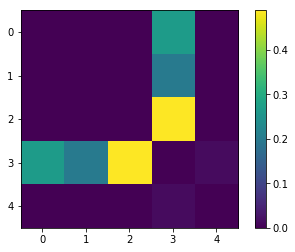

In [19]:
kernel1_new = kernelRBF(Z_new, theta_rbf)
grad_dKdZ_numerical = (kernel1_new - kernel1) / tiny
plt.imshow(grad_dKdZ_numerical, interpolation = None)
plt.colorbar()

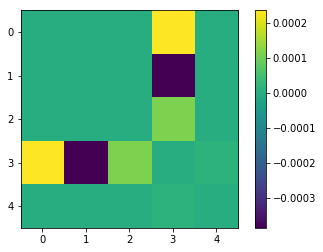

In [20]:
# difference between old and new kernel
plt.imshow(grad_dKdZ_numerical - grad_dKdZ_analytic, interpolation = None)
plt.colorbar()